In [54]:
from matplotlib import font_manager, rc
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)

# 1. 부트스트래핑
* 부트스트래핑(bootstrapping) : 데이터를 재표본화(re-sampling)하여 여러가지 다양한 표본 데이터 집합을 만든다.
    * 재표본화 시 기존의 $N$개 데이터에서 다시 $N$개 선택하되 중복 선택도 가능하게 한다.(unordered resamplling with replacement)
* 회귀분석에 사용한 표본 데이터가 달라질 때 회귀분석의 결과는 어느 정도 영향을 받는지를 알기 위한 방법
* 가중치의 오차 범위 혹은 신뢰 구간을 계산하기 위한 방법

#### 100개 가상 데이터에 대한 일반적인 확률론적 선형 회귀 모형
$$ y = w_0 + w_1x + ε$$

* 모형에 사용된 모수의 상수항 $w_0 = 0$ 
* 기울기 $w_1 = 42.3855$

In [55]:
from sklearn.datasets import make_regression

X0, y, coef = make_regression(n_samples=100, n_features=1, noise=20, coef=True,
                             random_state=0)
coef

array(42.38550486)

In [56]:
import pandas as pd
import statsmodels.api as sm

dfX0 = pd.DataFrame(X0, columns=["X1"])
dfX = sm.add_constant(dfX0)
dfy = pd.DataFrame(y, columns=["y"])

model = sm.OLS(dfy, dfX)
result = model.fit()

##### params
추정된 가중치와 상수항이 저장되어 있다.

In [57]:
result.params

const    -1.628364
X1       42.853356
dtype: float64

* 상수항 추정치 $\hat w_0 = -1.628364$  
* 기울기 추정치 $\hat w_1 = 42.853356$  

실제 모수와 다르다.

#### 이 데이터를 재표본화(부트스트래핑)한 다른 데이터 집합으로 1,000번 회귀분석 반복

In [58]:
%%time
import numpy as np

N = 1000
params_w0 = np.zeros(N)
params_w1 = np.zeros(N)

for i in range(N):
    idx = np.random.choice(len(dfy), len(dfy), replace=True)
    dfX2 = dfX.iloc[idx, :]
    dfy2 = dfy.iloc[idx]
    r = sm.OLS(dfy2, dfX2).fit()
    params_w0[i] = r.params.const
    params_w1[i] = r.params.X1

Wall time: 2.65 s


#### 전체 가중치, 상수항 추정값 집합 히스토그램으로 나타내기

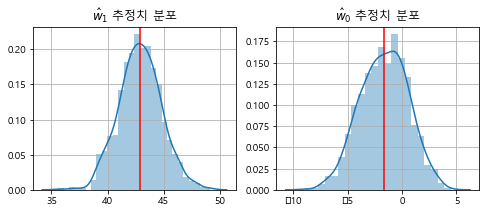

In [59]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 3))

ax1 = plt.subplot(121)
sns.distplot(params_w1, ax=ax1)
plt.axvline(params_w1.mean(), c='r')
plt.title("$\hat{w}_1$ 추정치 분포")
plt.grid()

ax2 = plt.subplot(122)
sns.distplot(params_w0, ax=ax2)
plt.axvline(params_w0.mean(), c='r')
plt.title("$\hat{w}_0$ 추정치 분포")
plt.grid()

plt.show()

#### 기울기의 추정치 분포 평균, 표준편차

In [60]:
params_w1.mean(), params_w1.std()

(42.92194788965001, 1.8968420262550838)

* 평균 : $42.72$
* 표준편차 : $1.93$    

대부분의 데이터가 $42.72 ± 3.86(\bar x ± 2s)$ 사이에 있다.  
따라서 오차가 큰 경우에도 0이나 음수가 될 가능성은 적다.

#### 상수항의 추정치 분포 평균, 표준편차

In [61]:
params_w0.mean(), params_w0.std()

(-1.640556066699144, 2.1891194088314228)

* 평균 : $-1.59$
* 표준편차 : $2.23$

대부분의 데이터가 $-1.59 ± 4.46(-6.05 ∼ 2.87)$ 사이에 있어 0일 수도 음수일 수도 있다.

##### summary
모델의 추정치 정보를 보여준다.

In [62]:
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.803
Model:                            OLS   Adj. R-squared:                  0.801
Method:                 Least Squares   F-statistic:                     400.3
Date:                Thu, 08 Nov 2018   Prob (F-statistic):           2.21e-36
Time:                        14:10:14   Log-Likelihood:                -448.09
No. Observations:                 100   AIC:                             900.2
Df Residuals:                      98   BIC:                             905.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.6284      2.163     -0.753      0.4

부트스트래핑한 회귀분석과 일반 회귀분석의 평균과 표준편차를 비교해보면 비슷하다.
* 부트스트래핑 평균 : 가중치 42.72, 상수항 -1.59  
확률론적 선형 회귀모형 평균 : 가중치 42.85 (`X1`의 `coef`), 상수항 -1.62 (`const`의 `coef`)
* 부트스트래핑 표준편차 : 가중치 1.93, 상수항 2.23  
확률론적 선형 회귀모형 표준편차 : 가중치 2.14(`X1`의 `std err`), 상수항 2.16 (`const`의 `std err`)
* 부트스트래핑 $\bar x ± 2s$로 추정한 구간 : 가중치 38.86 ~ 46.58, 상수항 -6.05 ~ 2.87  
확률론적 선형 회귀모형 구간 `[0.025 0.975]` : 가중치 38.60 ~ 47.10, 상수항 -5.92 ~ 2.66

`summary` 보고서와 같이 확률론적 선형 회귀모형을 쓰면 부트스트래핑처럼 많은 계산을 하지 않아도 빠르고 안정적으로 가중치 추정값의 오차를 구할 수 있다.

# 2. 확률론적 선형 회귀모형
확률론적 선형 회귀모형에서는 데이터가 확률 변수로부터 생성된 표본이라고 가정한다.

 ## 2.1. 가정 1. 오차의 분포에 대한 가정
  ### 2.1.1. 선형 정규 분포 가정
  * 선형 회귀분석의 기본가정 : 종속 변수 $y$가 독립 변수 $x$의 선형 조합으로 결정되는 기댓값과 고정된 분산 $\sigma^2$을 가지는 가우시안 정규 분포이다.
  $$ y ∼ Ν(w^Tx, \sigma^2) $$
  * $y$의 확률밀도함수  
  $$ p(y|x, \theta) = Ν(y|w^Tx, \sigma^2) $$
  
  이 식에서 모수 벡터 $\theta = (w, \sigma^2)$이다.
  * 잡음(disturbance) $\epsilon$ 개념으로 변환하여 더 간단히 표현
  $$ \epsilon = y - w^Tx $$
  $$ p(\epsilon|\theta) = Ν(0, \sigma^2) $$
  * 주의할 점
  > $x, y$ 중 그 어느 것도 그 자체로 정규 분포일 필요는 없다.
  
  $y$도 $x$에 대해 조건부로 정규 분포를 이루는 것이지 $y$ 자체가 무조건부로 정규분포는 아니다.

   ### 2.1.2. 외생성(Exogeneity) 가정
   * 외생성 가정 : 잡음 $\epsilon$의 기댓값은 독립 변수 $x$의 크기에 상관없이 항상 0이라고 가정하는 것
   $$ E[\epsilon|x] = 0 $$
   * 외생성 가정으로부터 잡음 $\epsilon$의 무조건부 기댓값이 0임을 증명할 수 있다.
   $$ E[\epsilon] = E[E[\epsilon|x]] = 0 $$
   역은 성립하지 않는다.  
   즉 조건부 기댓값이 0이면 기댓값은 0이지만, 기댓값이 0이라고 조건부 기댓값이 0이 되지는 않는다.
   * 같은 가정으로부터 잡음 $\epsilon$와 독립 변수 $x$가 상관 관계가 없다는 것도 증명할 수 있다.
   $$ E[\epsilon x] = E[E[\epsilon x|x]] = E[xE[\epsilon|x]] = 0 $$

   ### 2.1.3. 조건부 독립 가정
   * $i$번째 샘플의 잡음 $\epsilon_i$와 $j$번째 샘플의 잡음 $\epsilon_j$의 공분산 값이 $x$와 상관없이 항상 0이라고 가정한다.
   $$ Cov[\epsilon_i, \epsilon_j|x] = 0 \text{ (i,j = 1,2,...,N)} $$
   이는 $i$번째 샘플 잡음 $\epsilon_i$와 $j$번째 샘플 잡음 $\epsilon_j$는 서로 독립이라는 가정과 같다.
   * 이 가정과 위의 다른 가정들로부터 다음을 증명할 수 있다.
   $$ E[\epsilon_i\epsilon_j] = 0 \text{ (i,j = 1,2,...,N)} $$
   이를 공분산 행렬 형태로 표현
   $$ Cov[\epsilon] = E[\epsilon \epsilon^T] = \sigma^2I $$

 ## 2.2. 가정 2. 독립 변수에 대한 가정
 * 독립 변수의 특징 행렬 $X$는 풀랭크(full rank)이어야 한다.  
 즉, 독립 변수에서 서로 독립인 성분이 독립 변수 갯수만큼 존재해야 한다.
 * 독립 변수의 특징 행렬 $X$이 풀랭크이면 공분산 행렬 $X^TX$도 풀랭크가 되어 공분산 행렬의 역행렬이 존재한다.

# 3. 최대 가능도 방법을 사용한 선형 회귀분석
#### 확률론적 선형 회귀모형의 가정과 최대 가능도 방법(Maximum Likelihood Estimation)을 사용한 가중치 벡터 $w$ 구하기
* 가능도
$$ p(y_1:N|x_1:N, \theta) = \prod_{i=1}^NΝ(y_i|w^Tx_i, \sigma^2) $$
$$ = \prod_{i=1}^N\frac{1}{\sqrt{2\pi\sigma^2}}exp\{-\frac{(y_i - w^Tx_i)^2}{2\sigma^2}\} $$
* 로그 가능도(log-likelihood)
$$ LL = logp(y_1:N|x_1:N, \theta) $$
$$ = log\prod_{i=1}^N\frac{1}{\sqrt{2\pi\sigma^2}}exp\{-\frac{(y_i - w^Tx_i)^2}{2\sigma^2}\} $$
$$ = -\frac{1}{2\sigma^2}\sum_{i=1}^N(y_i - w^Tx_i)^2 - \frac{N}{2}log2\pi\sigma^2 $$
* 행렬로 표시
$$ LL = -C_1(y - Xw)^T(y - Xw) - C_0 = -C_1(w^Tx^TXw - 2y^TXw + y^Ty) - C_0 $$
$$ C1 = -\frac{1}{2\sigma^2} $$
$$ c_0 = \frac{N}{2}log2\pi\sigma^2 $$
* 최적화하면 OLS와 동일한 결과를 얻는다.
$$ \frac{\partial}{\partial w}LL = -C_1(2X^TX\hat w - 2X^Ty) = 0 $$
$$ \hat w = (X^TX)^{-1}X^Ty $$
* 최대 가능도 방법에서도 OLS의 직교 방정식과 같은 직교 방정식을 얻을 수 있다.
$$ X^TX\hat w - X^Ty = 0 $$
$$ X^T(X\hat w - y) = X^T(\hat y - y) = X^Te = 0 $$

# 4. 잔차의 분포
확률론적 선형 회귀모형에 따르면 회귀분석에서 생기는 잔차 $e = y - \hat w^Tx$도 정규분포를 따른다.
> **증명**    
* 확률론적 선형 회귀모형의 잡음 $\epsilon$와 잔차 $e$는 다음의 관계를 가진다.
$$ \hat y = X\hat w = X(X^TX)-1X^Ty = Hy $$
    * $H$ : Hat 행렬, 프로젝션(projection) 행렬, 영향도(influence) 행렬이라고 부르는 대칭 행렬
* Hat 행렬을 이용한 잔차 표현
$$ e = y - \hat y = y - Hy = (I - H)y = My $$
    * $M$ : 잔차(residual) 행렬이라고 부르는 대칭 행렬
* 확률적 선형 회귀 모형의 가정을 적용
$$e = My = M(Xw + \epsilon) = MXw + M\epsilon $$
* $MX = 0$이므로
$$ e = M\epsilon $$

즉, 잔차 $e$는 잡음 $\epsilon$의 선형 변환(linear transform)이다.  
정규분포의 선형 변환은 마찬가지고 정규분포이므로, 잔차도 정규 분포를 따른다.

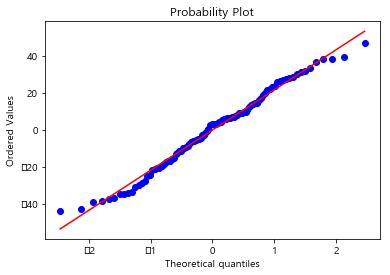

In [63]:
import scipy as sp

sp.stats.probplot(result.resid, plot=plt)
plt.show()

#### 정규성 검정을 통해 정규성 살펴보기

In [64]:
test = sm.stats.omni_normtest(result.resid)

for xi in zip(['Chi^2', 'P-value'], test):
    print("%-12s: %6.3f" % xi)

Chi^2       :  3.523
P-value     :  0.172


In [65]:
test = sm.stats.jarque_bera(result.resid)

for xi in zip(['Jarque-Bera', 'P-value', 'Skew', 'Kurtosis'], test):
    print("%-12s: %6.3f" % xi)

Jarque-Bera :  2.059
P-value     :  0.357
Skew        : -0.073
Kurtosis    :  2.312


오차의 기댓값이 $x$와 상관없이 0이므로 잔차의 기댓값도 $x$와 상관없이 0이어야 한다.
$$ E[e|x] = 0 $$

#### $x$값이 달라짐에 따라 잔차의 분포의 변화 살펴보기

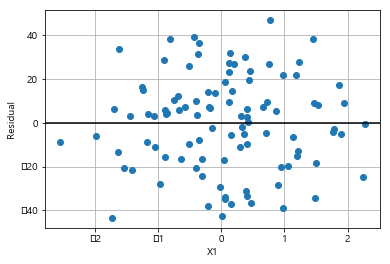

In [66]:
plt.plot(X0, result.resid, 'o')
plt.axhline(y=0, c='k')
plt.xlabel("X1")
plt.ylabel("Residual")
plt.grid()
plt.show()

$x$값이 달라져도 분포의 형태가 크게 바뀌지 않는다.

#### $x$가 $e$에 미치는 영향 살펴보기
$ 0 < x < 1, 1 < x < 2$ 구간으로 나누어 $e$ 분포의 모양을 살펴본다. 

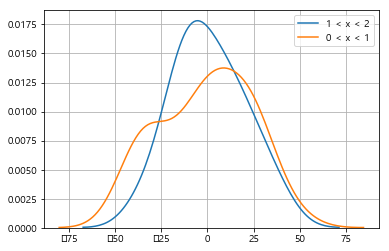

In [67]:
sns.kdeplot(result.resid[((1 < X0) & (X0 < 2)).flatten()], label="1 < x < 2")
sns.kdeplot(result.resid[((0 < X0) & (X0 < 1)).flatten()], label="0 < x < 1")
plt.legend()
plt.grid()
plt.show()

# 5. 회귀 계수의 표준 오차
* 가중치의 예측치 $\hat w$도 정규분포 확률변수인 $\epsilon$의 선형 변환이므로 정규분포를 따른다.
$$ \hat w = (X^TX)^{-1}X^Ty $$
$$ = (X^TX)^{-1}X^T(Xw + \epsilon) $$
$$ = w + (X^TX)^{-1}X^T\epsilon $$